# Plotting Tools
Some basic plotting tools used throughout the notebook.

In [1]:
# Plot 2 images side-by-side
def plot_sbs(img1, img2, cmap1 = 'brg', cmap2 = 'brg'):
    
    plt.figure(figsize = (16, 20))
    plt.subplot(1,2,1)
    plt.imshow(img1, cmap1)
    plt.subplot(1,2,2)
    plt.imshow(img2, cmap2)

    
def plot_imgs(X, title=[], cols = 6, cmap='brg'):
    
    num_cols = cols
    num_plots = len(X)
    num_rows = int(math.ceil(num_plots/2))
    
    plotNum = 1
    plt.figure(figsize = (16, num_rows*4))
    for i in range(num_plots):
        plt.subplot(num_rows, num_cols, plotNum)
        plt.imshow(X[i], cmap=cmap)
        if(title):
            plt.title(title[i])
        plotNum = plotNum + 1

# Extract Sample Images from Challenge Video
Here, I'll grab some images for use throughout this notebook.

In [2]:
import cv2
import numpy as np
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


from moviepy.editor import VideoFileClip

# Times for frames to extract
times = np.arange(0,50,5)

clear1 = None
clip1 = VideoFileClip("project_video.mp4")

raw_imgs = []

for time in times:
    raw_imgs.append(clip1.get_frame(time))
    

# Camera Calibration

In [3]:

import glob

# Read in images
cal_files = glob.glob('camera_cal/*.jpg')

cal_imgs = []
for file in cal_files:
    cal_imgs.append(mpimg.imread(file)) #RGB image
    
"""
for img in cal_imgs:
    plt.figure()
    plt.imshow(img)
"""

'\nfor img in cal_imgs:\n    plt.figure()\n    plt.imshow(img)\n'

In [4]:

def cal_camera(imgs, nc = (9,6), plots = False):
    
    objpoints = []
    imgpoints = []
    
    objp = np.zeros((nc[0]*nc[1], 3), np.float32)
    objp[:,:2] = np.mgrid[0:nc[0], 0:nc[1]].T.reshape(-1,2)
    
    shape = imgs[0].shape[1::-1]
    
    for img in imgs:
        # Convert to grayscale
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, nc, None)

        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)

            #img = cv2.drawChessboardCorners(img, nc, corners, ret)
            #plt.figure()
            #plt.imshow(img)
    
    retval, matrix, distortion, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shape, None, None)
    
    return matrix, distortion



save_mtx = 'camera_cal/cam_cal_mtx.p'
save_dist = 'camera_cal/cam_cal_dist.p'

action = 'load'

if(action == 'gen'):
    mtx, dist = cal_camera(cal_imgs)
    pickle.dump(mtx, open(save_mtx, "wb" ))
    pickle.dump(dist, open(save_dist, "wb" ))
elif(action == 'load'):
    with open(save_mtx, mode='rb') as f:
        mtx = pickle.load(f)
    with open(save_dist, mode='rb') as f:
        dist = pickle.load(f)
else:
    print("Choose whether to generate or load camera calibration data.")
    

# Undistort Images


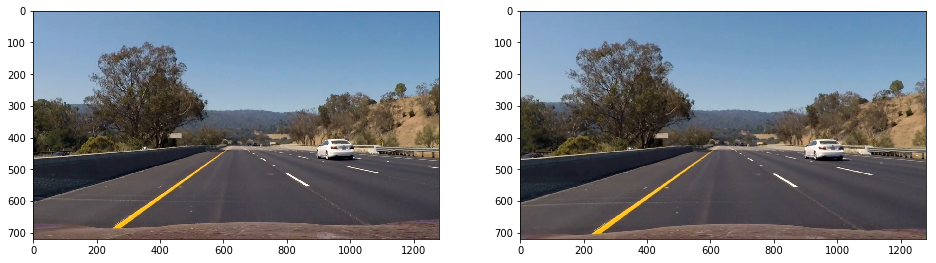

In [5]:
# Undistort an image

def undistort(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

undist_imgs = []

for img in raw_imgs:
    undist_imgs.append(undistort(img, mtx, dist))

plot_sbs(raw_imgs[4], undist_imgs[4])

# Thresholding

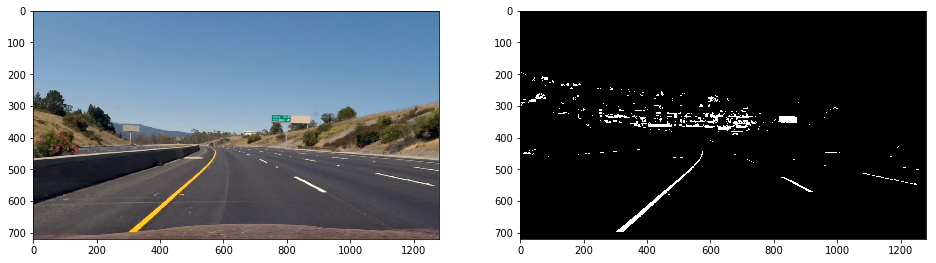

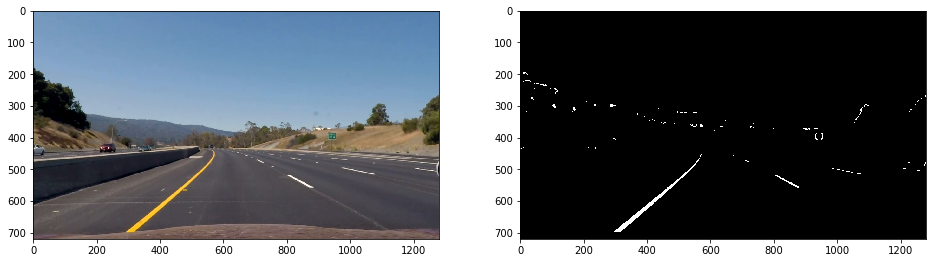

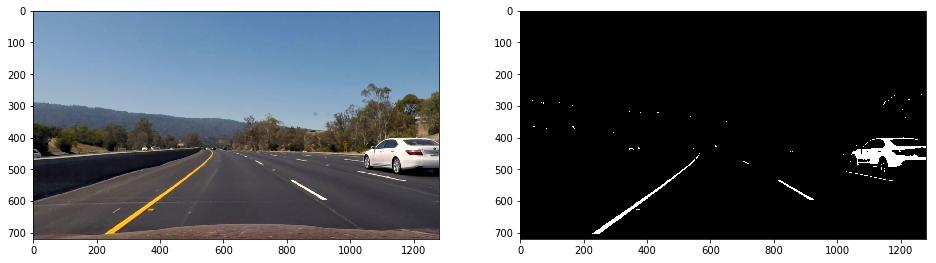

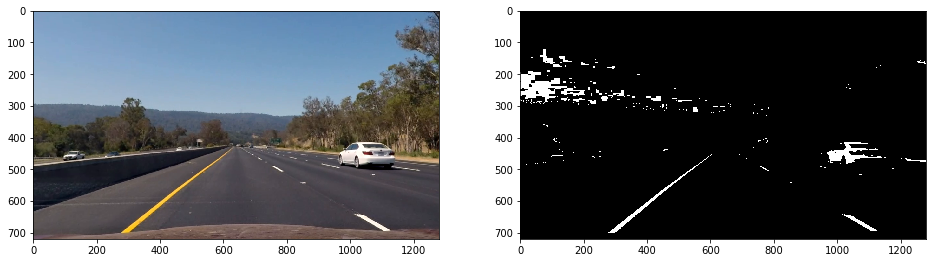

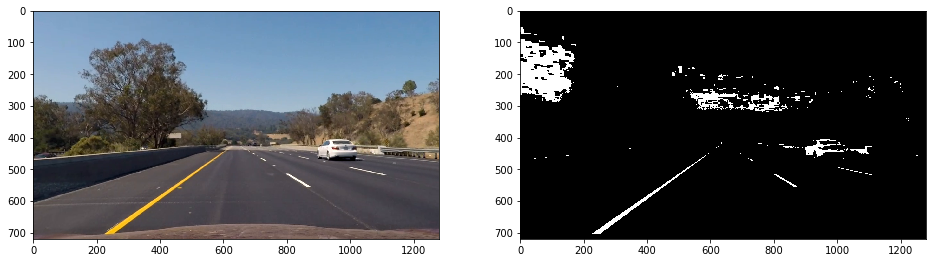

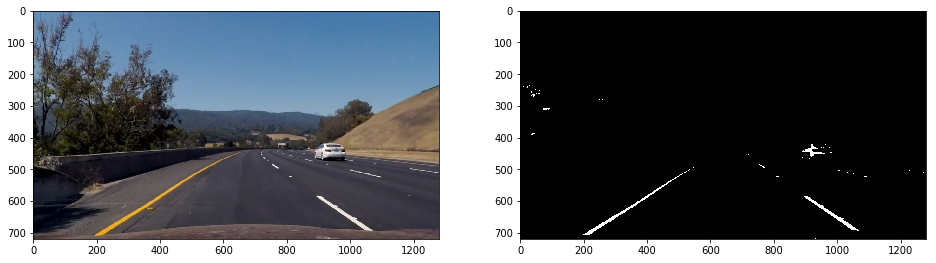

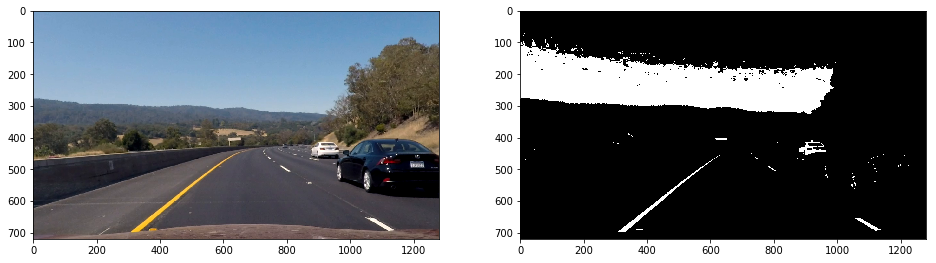

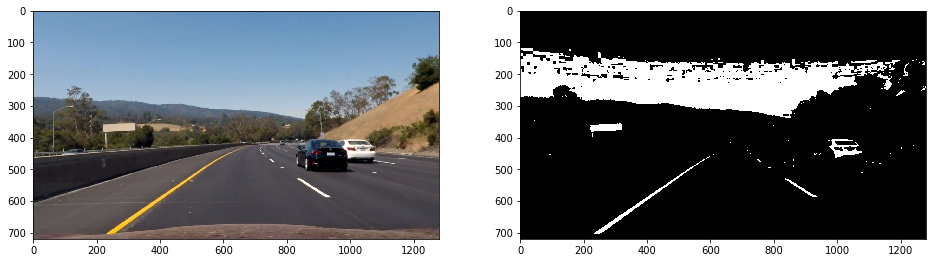

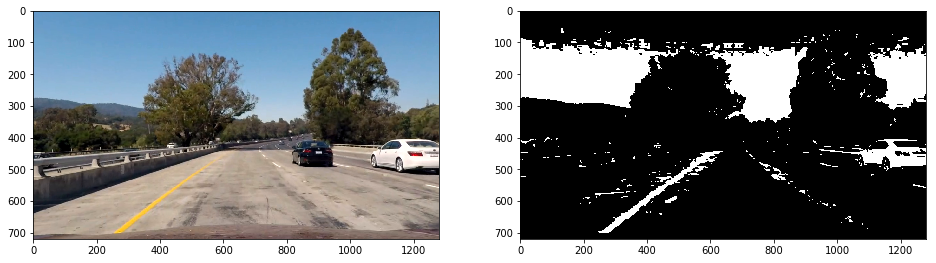

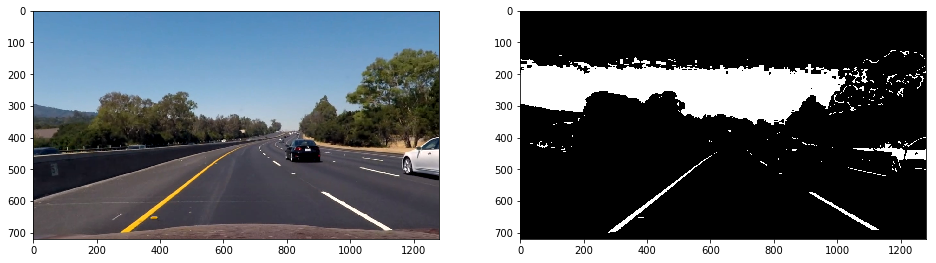

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh = (0, 255)):
    
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output


def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
   
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    return binary_output


def hls_select(img, thresh=(0, 255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    binary_output = np.zeros_like(s_channel)
    binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    return binary_output

def hsv_select(img, color1_lower, color1_upper, color2_lower, color2_upper):
    """ Applies an HSV color transform, and performs color selection of two colors
    Color selection was performed in the HSV color space, since it's much easier to pick
    out individual colors than in RGB space
    """
    #Convert to hsv
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    # Generate masks
    mask2 = cv2.inRange(hsv, color2_lower, color2_upper)
    mask1 = cv2.inRange(hsv, color1_lower, color1_upper)
    
    
    # Apply mask to original image
    mask = cv2.bitwise_or(mask1, mask2)
    
    binary_output = np.zeros_like(mask).astype(np.uint8)
    binary_output[mask>0] = 1; # convert to 0-1
    
    return binary_output


def red_select(img, thresh=(0,255)):
    red = img[:,:,0]
    binary_output = np.zeros_like(red)
    binary_output[(red > thresh[0]) & (red <= thresh[1])] = 1
    return binary_output


def thresh_fcn(img, ksize=5, xythresh=(20,100), magthresh=(10,100), 
               dirthresh=(0.6, 1.0), redthresh=(170,255), hlsthresh=(80,255), plot = False):
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=xythresh)
    if False:
        plt.figure()
        plt.imshow(gradx, cmap='gray')
        plt.title('X Grad')
    
    """
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=xythresh)
    plt.figure()
    plt.imshow(grady, cmap='gray')
    plt.title('Y Grad')
    """
    # Define yellow and white colors for used in color selection
    lower_yellow = np.array([40, 40, 40])
    upper_yellow = np.array([70, 255, 255])
    lower_white = np.array([0, 0, 205])
    upper_white = np.array([255, 255, 255])
    
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=magthresh)
    if False:
        plt.figure()
        plt.imshow(mag_binary, cmap='gray')
        plt.title('Grad Magnitude')
    
    dir_binary = dir_threshold(gray, sobel_kernel=15, thresh=dirthresh)
    if False:
        plt.figure()
        plt.imshow(dir_binary, cmap='gray')
        plt.title('Grad Dir')
    
    red_binary = red_select(img, thresh=redthresh)
    if plot:
        plt.figure()
        plt.imshow(red_binary, cmap='gray')
        plt.title('Red')
    
    hls_binary = hls_select(img, thresh=hlsthresh)
    if plot:
        plt.figure()
        plt.imshow(hls_binary, cmap='gray')
        plt.title('HLS')
        
        
    hsv_binary = hsv_select(img, lower_yellow, upper_yellow, lower_white, upper_white)
    if plot:
        plt.figure()
        plt.imshow(hsv_binary, cmap='gray')
        plt.title('HSV Select')

    newimg = np.zeros_like(img[:,:,0])
    #newimg[(((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #removed the y grad
    #newimg[((gradx == 1) | ((mag_binary == 1) & (dir_binary == 1))) & (red_binary == 1) & (hls_binary == 1)] = 1
    
    #Using only HLS and red
    #newimg[ (red_binary == 1) & (hls_binary == 1)] = 1
    
    newimg[(hsv_binary == 1)] = 1
    
    
    return newimg

"""
test_img = cv2.cvtColor(raw_imgs[14], cv2.COLOR_RGB2HLS)
s_channel = test_img[:,:,2]
plt.imshow(s_channel, cmap='gray')
"""

thresh_imgs = []
for i in range(len(undist_imgs)): #undist_imgs
    thresh_imgs.append(thresh_fcn(undist_imgs[i], plot=False))
    plot_sbs(undist_imgs[i], thresh_imgs[i], cmap2 = 'gray')
    
    

# Perspective Transform

In theory, any image (of the size that we're using, at least) that has been corrected for distortion could be used to determine how to warp the perspective to plot lane lines. Therefore, I'll do this with one of the provided "straight" line images, since frames with straight lines are scarce in the challenge video.

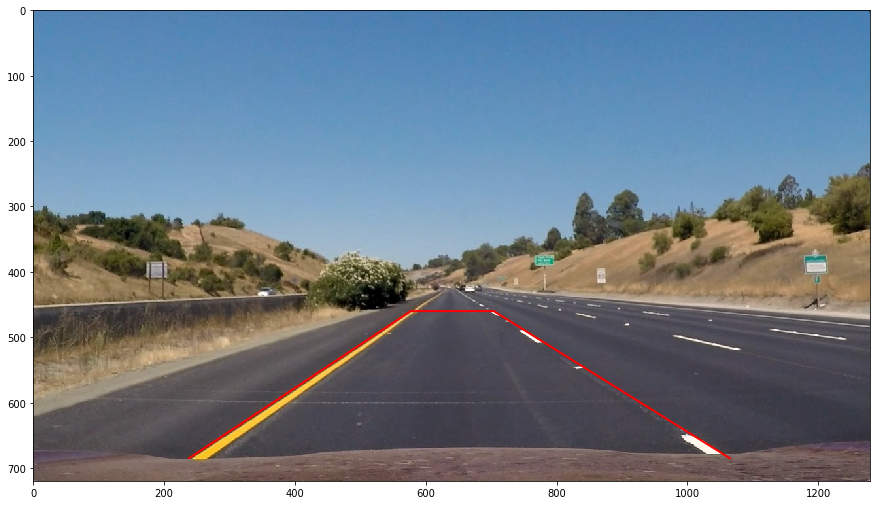

In [7]:
# Grab an image to use for calibrating the perspective warp
strt_img = mpimg.imread('test_images/straight_lines1.jpg')
shp = strt_img.shape

# Pick out some points - these were fine-tuned by hand
xpnts = [238, 577, 704, 1065]
ypnts = [shp[0]-35, 460, 460, shp[0]-35,]

# Plot points
plt.figure(figsize = (15,25));
plt.imshow(strt_img);
plt.plot(xpnts, ypnts, 'r-', linewidth=2);


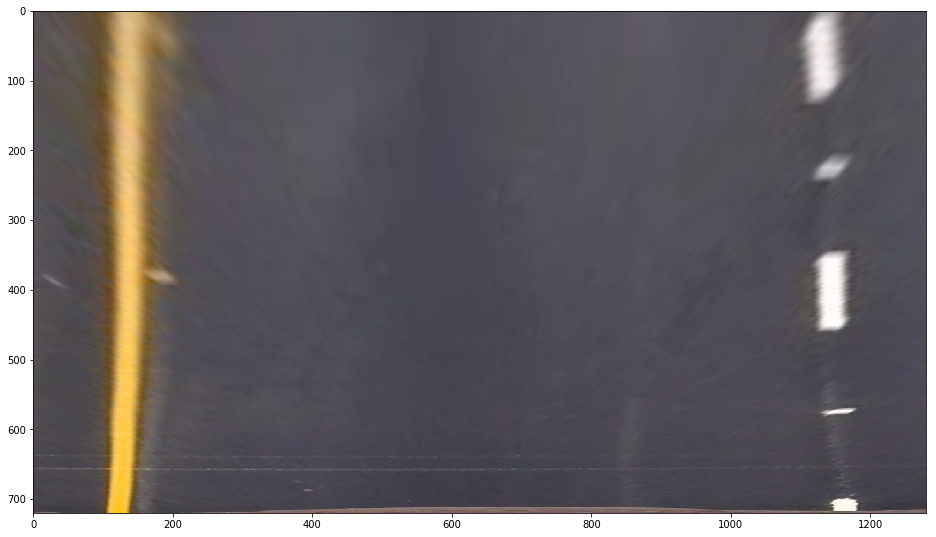

In [8]:
# Define a warping function to do the perspective transform
def warpPers(img):
    
    #Hard-coding the values here
    xpnts = [238, 577, 707, 1066]
    ypnts = [720-35, 460, 460, 720-35,]
    
    # Reshape to the format required by cv2
    srcx = np.array(xpnts)[np.newaxis].T
    srcy = np.array(ypnts)[np.newaxis].T
    src = np.concatenate((srcx, srcy), axis=1).astype(np.float32)
    
    ofst = 100
    dst = np.float32([[ofst, shp[0]], [ofst, 0], [shp[1]-ofst, 0], [shp[1]-ofst, shp[0]]])

    # Warp
    M = cv2.getPerspectiveTransform(src,dst)
    warped = cv2.warpPerspective(img, M, (shp[1], shp[0]))
    
    return warped

plt.figure(figsize=(16, 24));
plt.imshow(warpPers(strt_img));

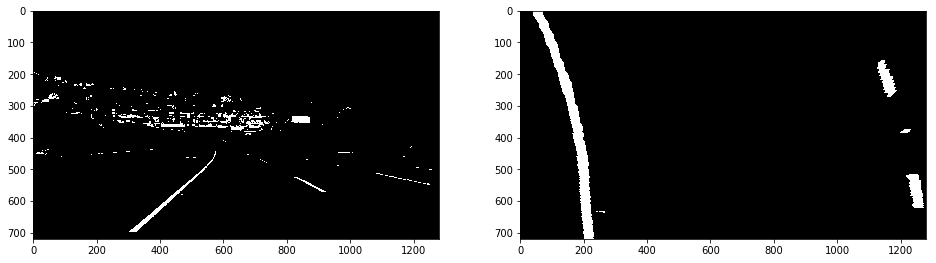

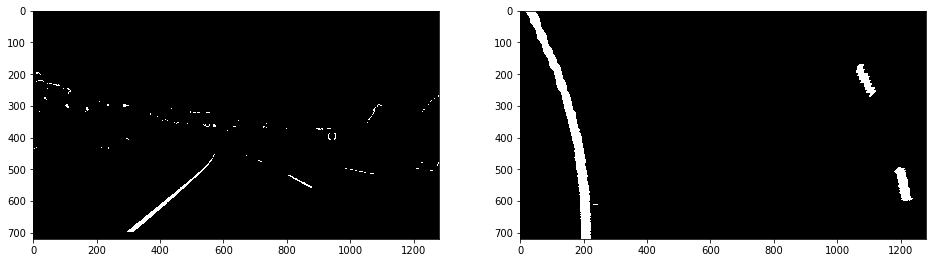

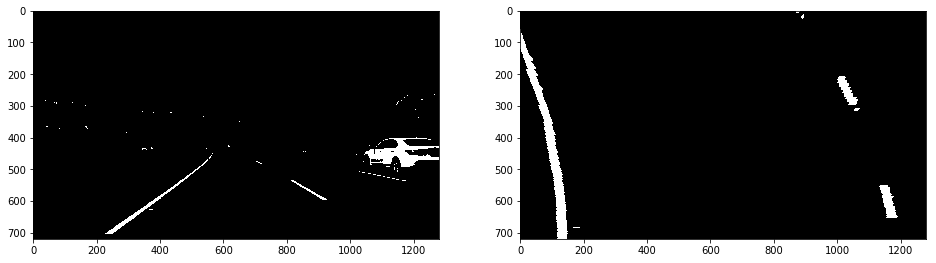

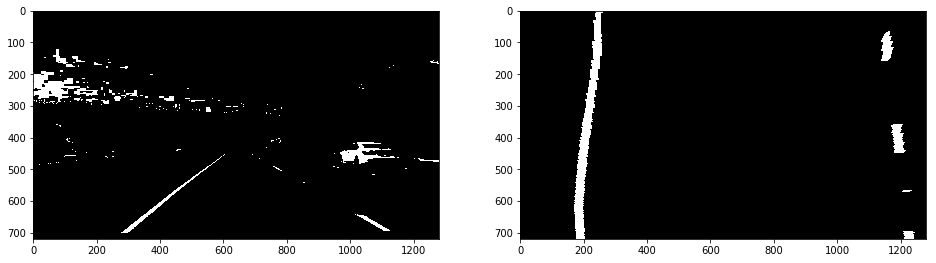

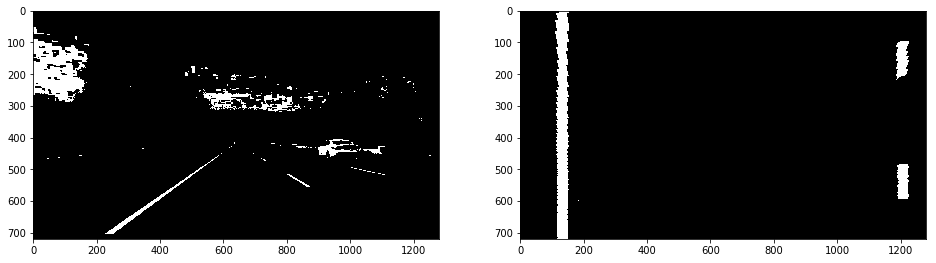

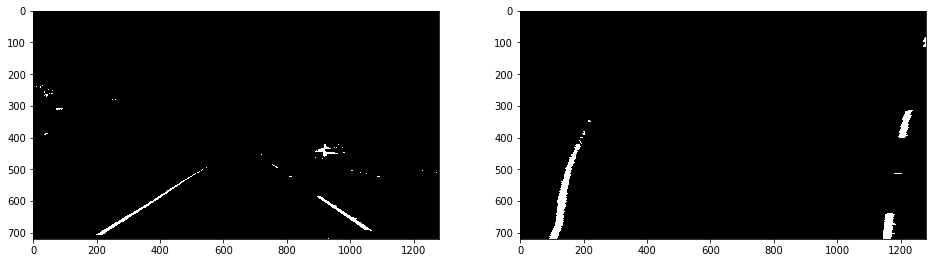

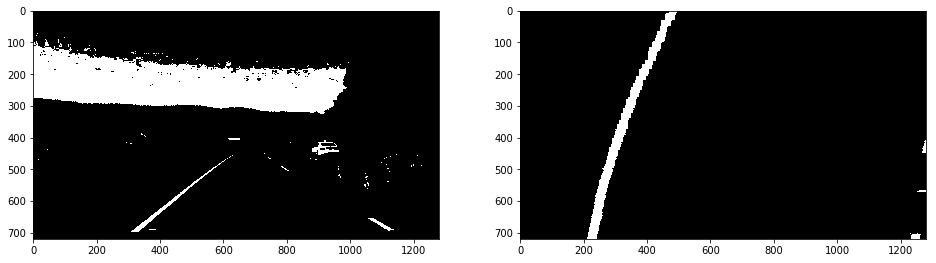

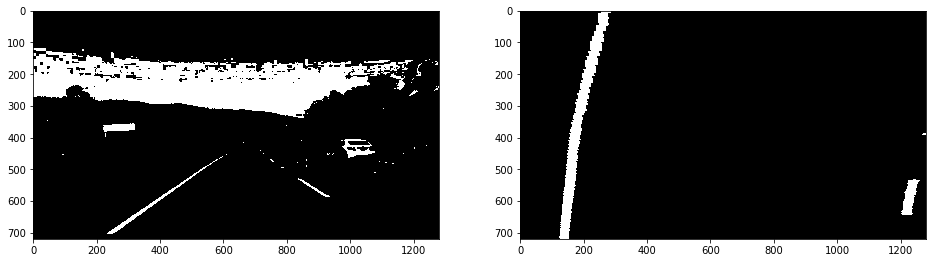

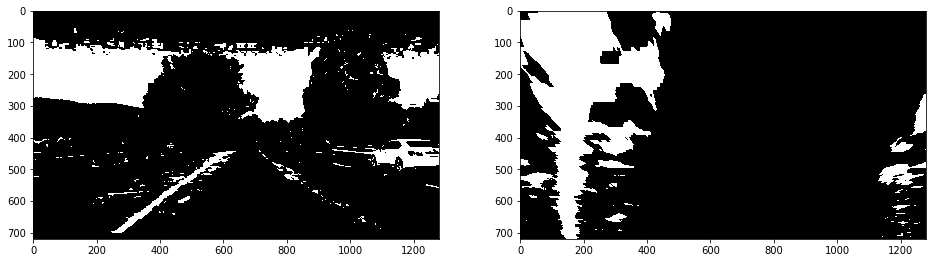

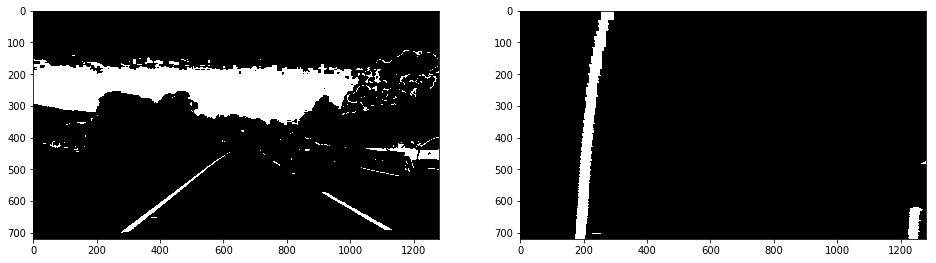

In [9]:
# Try on a few images from the video

warp_imgs = []
for img in thresh_imgs:
    warp_imgs.append(warpPers(img))
    plot_sbs(img, warp_imgs[-1], cmap1='gray', cmap2='gray')
    


# Finding Lane Lines

'\nfor img in warp_imgs:\n    plt.figure()\n    plt.plot(lane_hist(img))\n'

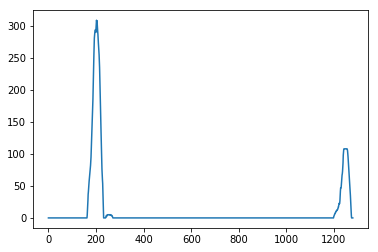

In [10]:
def lane_hist(img):
    # Grab only the bottom half of the image
    # Lane lines are likely to be mostly vertical nearest to the car
    bottom_half = img[img.shape[0]//2:,:]

    # Sum across image pixels vertically - make sure to set an `axis`
    # i.e. the highest areas of vertical lines should be larger values
    histogram = np.sum(bottom_half, axis=0)
    
    return histogram

plt.plot(lane_hist(warp_imgs[0]))

"""
for img in warp_imgs:
    plt.figure()
    plt.plot(lane_hist(img))
"""


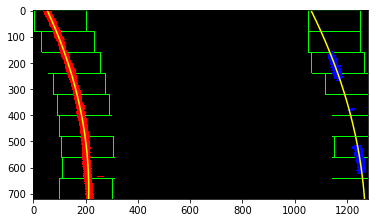

In [27]:
def find_lane_pixels(img):
    # Take a histogram of the bottom half of the image
    histogram = lane_hist(img)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((img, img, img))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(img.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img



def fit_polynomial(img_shp, leftx, lefty, rightx, righty):

    mx = 3.7/700
    my = 30/720
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty*my, leftx*mx, 2)
    right_fit = np.polyfit(righty*my, rightx*mx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shp[0]-1, img_shp[0] )*my
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.figure()
    plt.plot(left_fitx/mx, ploty/my, color='yellow')
    plt.plot(right_fitx/mx, ploty/my, color='yellow')

    return left_fit, right_fit, left_fitx, right_fitx, ploty, out_img


img = warp_imgs[0]
leftx, lefty, rightx, righty, out_img = find_lane_pixels(img)
left_fit, right_fit, left_fitx, right_fitx, ploty, out_img = fit_polynomial(img.shape, leftx, lefty, rightx, righty)

plt.imshow(out_img)

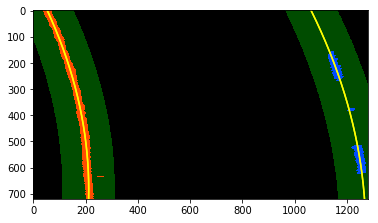

In [17]:
def search_around_poly(img, left_fit_prev, right_fit_prev):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
                    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
                    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
                    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
                    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fit_new, right_fit_new, left_fitx, right_fitx, ploty, o = fit_polynomial(img.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow');
    plt.plot(right_fitx, ploty, color='yellow');
    ## End visualization steps ##
    
    return left_fit_new, right_fit_new, result

left_fit, right_fit, result = search_around_poly(img, left_fit, right_fit)

plt.imshow(result)


# Calculate Curvature

In [21]:
def calc_curv(y_val, left_fit, right_fit, xm, ym):
    left_curv = ((1 + (2*left_fit[0]*y_vals*ym + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curv = ((1 + (2*right_fit[0]*y_vals*ym + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
    return left_curv, right_curv


y_vals = np.linspace(0, img.shape[0]-1, img.shape[0])

l_curv, r_curv = calc_curv(left_fit, right_fit, 500)
print("Left: ", l_curv, "   Right: ", r_curv)

Left:  1516.02943986    Right:  1809.81821403
